In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

/Users/ma3ti/miniconda3/envs/swin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.29G/2.29G [02:29<00:00, 16.5MB/s]

Extracting files...


Path to dataset files: /Users/ma3ti/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
import os
import random
import shutil
from tqdm import tqdm

dataset_path = './../dataset/chest_xray'      
new_dataset_path = './../dataset/chest_xray_new' 

if not os.path.exists(new_dataset_path):
    print(f"Creazione cartelle in {new_dataset_path}...")
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    print("Raccolta e mescolamento file...")
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']: # Raccoglie da tutte le vecchie split
            source_folder = os.path.join(dataset_path, split, cls)
            
            if not os.path.exists(source_folder):
                continue
                
            files = os.listdir(source_folder)
           
            valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
            files = [f for f in files if f.lower().endswith(valid_extensions)]
            
            all_files.extend([(file, source_folder) for file in files])

        random.shuffle(all_files)
        total_files = len(all_files)
        
        train_end = int(total_files * 0.8)
        val_end = int(total_files * 0.9)

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        print(f"Processing classe {cls}: Totale {total_files} -> Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

        def copy_files(file_list, split_name):
            dest_dir = os.path.join(new_dataset_path, split_name, cls)
            for file, source_folder in tqdm(file_list, desc=f"Copiando {cls} in {split_name}"):
                src = os.path.join(source_folder, file)
                dest = os.path.join(dest_dir, file)
                shutil.copy(src, dest)

        copy_files(train_files, 'train')
        copy_files(val_files, 'val')
        copy_files(test_files, 'test')

    print("\nFatto! Il nuovo dataset è pronto.")
else:
    print(f"La cartella {new_dataset_path} esiste già. Cancellala se vuoi ricrearla.")

Creazione cartelle in dataset/chest_xray_new...
Raccolta e mescolamento file...
Processing classe NORMAL: Totale 1583 -> Train: 1266, Val: 158, Test: 159


Copiando NORMAL in test: 100%|██████████| 159/159 [00:00<00:00, 1054.35it/s]


Processing classe PNEUMONIA: Totale 4273 -> Train: 3418, Val: 427, Test: 428


Copiando PNEUMONIA in test: 100%|██████████| 428/428 [00:00<00:00, 2002.46it/s]


Fatto! Il nuovo dataset è pronto.


Analisi del dataset in: dataset/chest_xray_new...

TRAIN - NORMAL: 1266 immagini
TRAIN - PNEUMONIA: 3418 immagini
VAL - NORMAL: 158 immagini
VAL - PNEUMONIA: 427 immagini
TEST - NORMAL: 159 immagini
TEST - PNEUMONIA: 428 immagini


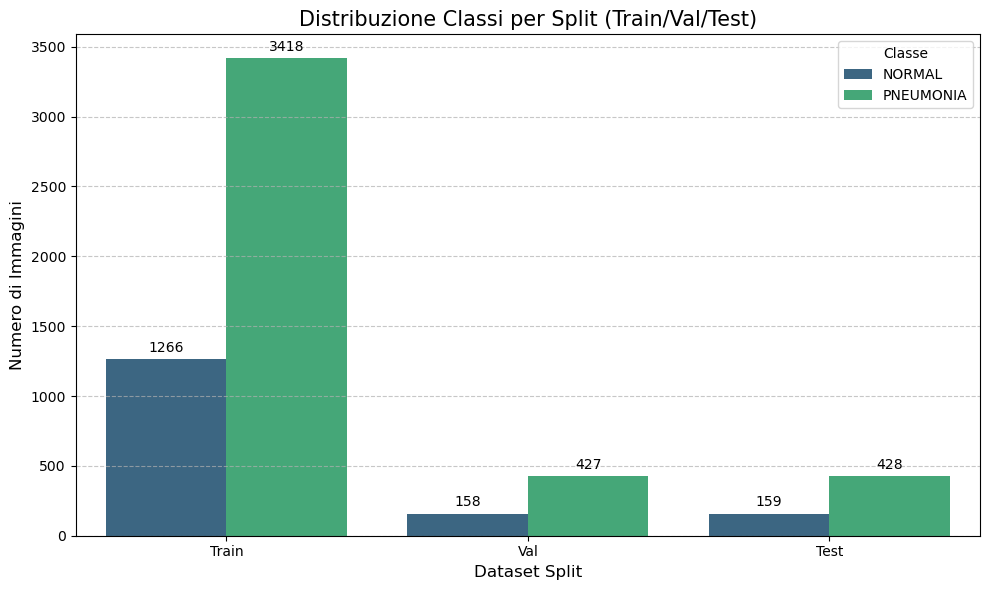


Totale Immagini: 5856
Percentuali Reali -> Train: 80.0%, Val: 10.0%, Test: 10.0%


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurazione del percorso (SENZA slash iniziale per evitare errori su Mac)
dataset_path = './../dataset/chest_xray_new'
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

def count_images():
    data = []
    
    print(f"Analisi del dataset in: {dataset_path}...\n")
    
    for split in splits:
        for cls in classes:
            folder_path = os.path.join(dataset_path, split, cls)
            
            count = 0
            if os.path.exists(folder_path):
                # Conta solo i file immagine, ignorando .DS_Store
                files = [f for f in os.listdir(folder_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                count = len(files)
            
            data.append({
                'Split': split.capitalize(), # Es: 'Train'
                'Class': cls,                # Es: 'NORMAL'
                'Count': count
            })
            print(f"{split.upper()} - {cls}: {count} immagini")
            
    return pd.DataFrame(data)

def plot_distribution(df):
    plt.figure(figsize=(10, 6))
    
    # Creazione del grafico a barre
    # x = Split (Train, Val, Test)
    # y = Numero immagini
    # hue = Colore diverso per classe (Normal vs Pneumonia)
    ax = sns.barplot(data=df, x='Split', y='Count', hue='Class', palette='viridis')
    
    # Aggiungi i numeri sopra le barre
    for container in ax.containers:
        ax.bar_label(container, padding=3)

    plt.title('Distribuzione Classi per Split (Train/Val/Test)', fontsize=15)
    plt.ylabel('Numero di Immagini', fontsize=12)
    plt.xlabel('Dataset Split', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Sposta la legenda in una posizione comoda
    plt.legend(title='Classe')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if os.path.exists(dataset_path):
        df_counts = count_images()
        plot_distribution(df_counts)
        
        # Calcolo percentuali totali per verifica
        total_imgs = df_counts['Count'].sum()
        print(f"\nTotale Immagini: {total_imgs}")
        
        # Verifica veloce delle proporzioni
        train_count = df_counts[df_counts['Split']=='Train']['Count'].sum()
        val_count = df_counts[df_counts['Split']=='Val']['Count'].sum()
        test_count = df_counts[df_counts['Split']=='Test']['Count'].sum()
        
        print(f"Percentuali Reali -> Train: {train_count/total_imgs:.1%}, Val: {val_count/total_imgs:.1%}, Test: {test_count/total_imgs:.1%}")
    else:
        print(f"Errore: La cartella '{dataset_path}' non esiste. Verifica il percorso.")